# Pseudogene vs Real Gene: Embeddings, Similarity, PCA

This section loads sequences from `result/sequences`, computes embeddings per iteration,
saves them as `.pkl`, plots cosine/baseline similarity, and runs PCA trajectories.


In [1]:
import sys
import gc
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import torch

# Add project paths for module imports
current_dir = Path('.').resolve()
project_root = current_dir.parent
dna_module_path = project_root / 'dna-model-collapse'
for path in [str(project_root), str(dna_module_path)]:
    if path not in sys.path:
        sys.path.insert(0, path)

from preparation import get_device, load_models

print('Imports ready')


Imports ready


In [2]:
# Paths
SEQ_DIR = current_dir / 'result' / 'sequences'
EMB_DIR = current_dir / 'result' / 'embeddings'
EMB_DIR.mkdir(parents=True, exist_ok=True)

# Gene pairs
GENE_PAIRS = [
    ('GAPDH', 'GAPDHP1'),
    ('PTEN', 'PTENP1'),
    ('TPI1', 'TPI1P1'),
]

def parse_mask_ratio(strategy_key):
    try:
        return float(strategy_key.split('_m')[-1])
    except Exception:
        return 0.0

print('Sequence dir:', SEQ_DIR)


Sequence dir: /Users/leeminjae/Desktop/01_Projects/iterative reconstruction of DNA sequence/iterative-dna-reconstruction/pseudogene-to-realgene/result/sequences


In [3]:
# Load models
device = get_device()
model_configs = {
    'DNABERT-2': 'zhihan1996/DNABERT-2-117M',
    'NT-v2-500m': 'InstaDeepAI/nucleotide-transformer-v2-500m-multi-species',
}
models = load_models(device, model_configs=model_configs)


PyTorch Version: 2.9.1
Using device: mps
📥 Downloading DNABERT-2...


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

✅ DNABERT-2 Triton patch applied successfully.
[DNABERT-2] Loading model...


/Users/leeminjae/.cache/huggingface/modules/transformers_modules/_7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


[DNABERT-2] Model loaded successfully.
✅ DNABERT-2 loaded successfully.
[NT-v2-500m] Loading model...
[NT-v2-500m] Model loaded successfully.
✅ NT-v2-500m loaded successfully.

🚀 2 model(s) ready!


In [4]:
# Load sequences from CSV
def load_gene_sequences(model_name, gene_name):
    csv_path = SEQ_DIR / model_name / f'{gene_name}.csv'
    if not csv_path.exists():
        raise FileNotFoundError(csv_path)
    df = pd.read_csv(csv_path, index_col=0)
    return {
        strategy: df.loc[strategy].tolist()
        for strategy in df.index
    }

sequence_data = {}
for model_label in models.keys():
    model_name = model_label.replace('/', '-')
    sequence_data[model_label] = {}
    for real_gene, pseudo_gene in GENE_PAIRS:
        for gene_name in (real_gene, pseudo_gene):
            if gene_name not in sequence_data[model_label]:
                sequence_data[model_label][gene_name] = load_gene_sequences(model_name, gene_name)

print('Loaded sequences for models:', list(sequence_data.keys()))


Loaded sequences for models: ['DNABERT-2', 'NT-v2-500m']


In [5]:
# Compute embeddings per iteration and save to .pkl
RECOMPUTE = False

def embed_sequences(model_instance, sequences_by_strategy):
    embeddings = {}
    for strategy, seq_list in sequences_by_strategy.items():
        emb_list = []
        for seq in seq_list:
            emb = model_instance.get_embedding(seq)
            emb_list.append(emb.squeeze(0))
        embeddings[strategy] = np.vstack(emb_list)

        gc.collect()
        if model_instance.device == 'cuda':
            torch.cuda.empty_cache()
        elif model_instance.device == 'mps':
            torch.mps.empty_cache()
    return embeddings

embedding_data = {}
for model_label, model_instance in models.items():
    model_name = model_label.replace('/', '-')
    embedding_data[model_label] = {}

    for gene_name, seq_strategies in sequence_data[model_label].items():
        out_dir = EMB_DIR / model_name
        out_dir.mkdir(parents=True, exist_ok=True)
        out_path = out_dir / f'{gene_name}.pkl'

        existing = {}
        if out_path.exists() and not RECOMPUTE:
            with open(out_path, 'rb') as f:
                existing = pickle.load(f)

        missing_strategies = [
            key for key in seq_strategies.keys()
            if key not in existing
        ]

        if RECOMPUTE or missing_strategies:
            targets = {
                key: seq_strategies[key]
                for key in (seq_strategies.keys() if RECOMPUTE else missing_strategies)
            }
            new_embeddings = embed_sequences(model_instance, targets)
            existing.update(new_embeddings)

            with open(out_path, 'wb') as f:
                pickle.dump(existing, f, protocol=pickle.HIGHEST_PROTOCOL)

            print(f'Saved embeddings: {out_path}')

        embedding_data[model_label][gene_name] = existing

print('Embedding computation complete')


Embedding computation complete


In [6]:
# Diagnostics: check iter0 cosine and embedding stats
def embedding_stats(x, label):
    x = np.asarray(x)
    finite_mask = np.isfinite(x)
    print(f'[{label}] shape={x.shape}, finite={finite_mask.mean():.4f}, min={np.nanmin(x):.3e}, max={np.nanmax(x):.3e}')

def cosine(a, b, eps=1e-12):
    a = np.asarray(a)
    b = np.asarray(b)
    denom = np.linalg.norm(a) * np.linalg.norm(b)
    return float(np.dot(a, b) / max(denom, eps))

for model_label in models.keys():
    print(f'=== {model_label} ===')
    for real_gene, pseudo_gene in GENE_PAIRS:
        real_strategies = set(embedding_data[model_label][real_gene].keys())
        pseudo_strategies = set(embedding_data[model_label][pseudo_gene].keys())
        strategies = sorted(real_strategies & pseudo_strategies, key=parse_mask_ratio)

        if not strategies:
            print(f'  {real_gene}-{pseudo_gene}: no shared strategies')
            continue

        for strategy in strategies:
            real_emb = embedding_data[model_label][real_gene][strategy]
            pseudo_emb = embedding_data[model_label][pseudo_gene][strategy]

            r0 = real_emb[0]
            p0 = pseudo_emb[0]
            sim0 = cosine(p0, r0)

            print(f'  {real_gene}-{pseudo_gene} {strategy}: iter0_cos={sim0:.4f}')
            embedding_stats(r0, f'{real_gene} {strategy} iter0')
            embedding_stats(p0, f'{pseudo_gene} {strategy} iter0')
            print(f'    norms: real={np.linalg.norm(r0):.3e}, pseudo={np.linalg.norm(p0):.3e}')
            print('')


=== DNABERT-2 ===
  GAPDH-GAPDHP1 sampling_t1.0_m0.15: iter0_cos=0.9881
[GAPDH sampling_t1.0_m0.15 iter0] shape=(768,), finite=1.0000, min=-6.581e-01, max=3.517e-01
[GAPDHP1 sampling_t1.0_m0.15 iter0] shape=(768,), finite=1.0000, min=-6.014e-01, max=3.218e-01
    norms: real=2.561e+00, pseudo=2.471e+00

  GAPDH-GAPDHP1 sampling_t1.0_m0.3: iter0_cos=0.9881
[GAPDH sampling_t1.0_m0.3 iter0] shape=(768,), finite=1.0000, min=-6.581e-01, max=3.517e-01
[GAPDHP1 sampling_t1.0_m0.3 iter0] shape=(768,), finite=1.0000, min=-6.014e-01, max=3.218e-01
    norms: real=2.561e+00, pseudo=2.471e+00

  GAPDH-GAPDHP1 sampling_t1.0_m0.45: iter0_cos=0.9881
[GAPDH sampling_t1.0_m0.45 iter0] shape=(768,), finite=1.0000, min=-6.581e-01, max=3.517e-01
[GAPDHP1 sampling_t1.0_m0.45 iter0] shape=(768,), finite=1.0000, min=-6.014e-01, max=3.218e-01
    norms: real=2.561e+00, pseudo=2.471e+00

  PTEN-PTENP1 sampling_t1.0_m0.15: iter0_cos=0.9182
[PTEN sampling_t1.0_m0.15 iter0] shape=(768,), finite=1.0000, min=-1.830

/var/folders/wm/m60tntks4_55jf79w27yb1t40000gn/T/ipykernel_20164/878952336.py:30: RuntimeWarning: divide by zero encountered in matmul
  baseline_sim = (pseudo_emb @ real_baseline) / (
/var/folders/wm/m60tntks4_55jf79w27yb1t40000gn/T/ipykernel_20164/878952336.py:30: RuntimeWarning: overflow encountered in matmul
  baseline_sim = (pseudo_emb @ real_baseline) / (
/var/folders/wm/m60tntks4_55jf79w27yb1t40000gn/T/ipykernel_20164/878952336.py:30: RuntimeWarning: invalid value encountered in matmul
  baseline_sim = (pseudo_emb @ real_baseline) / (


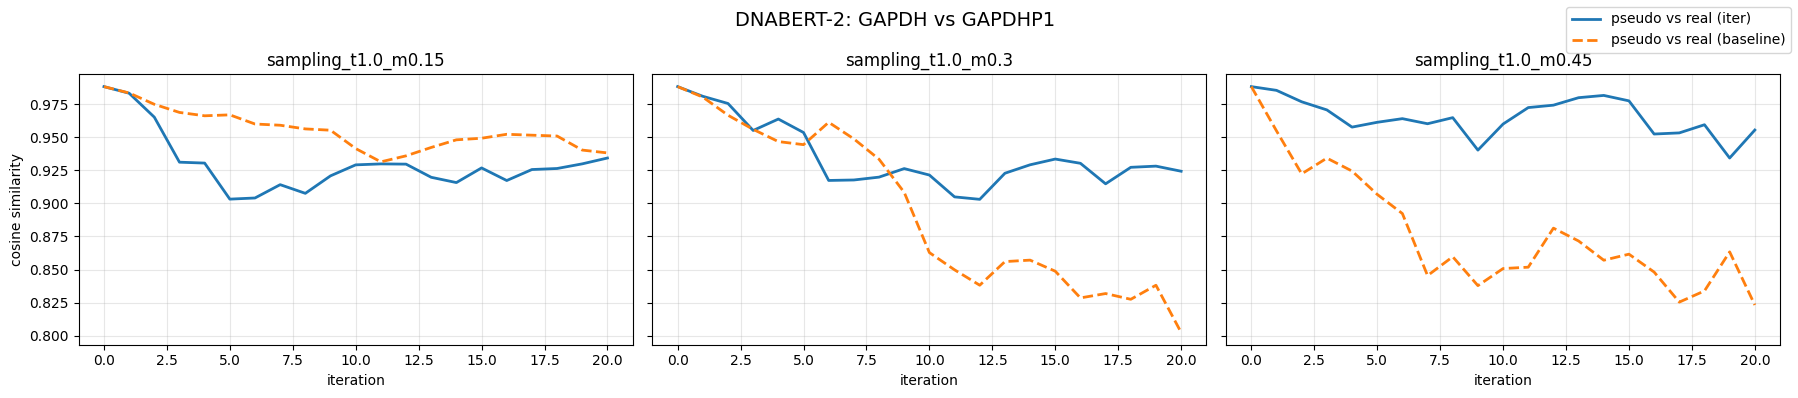

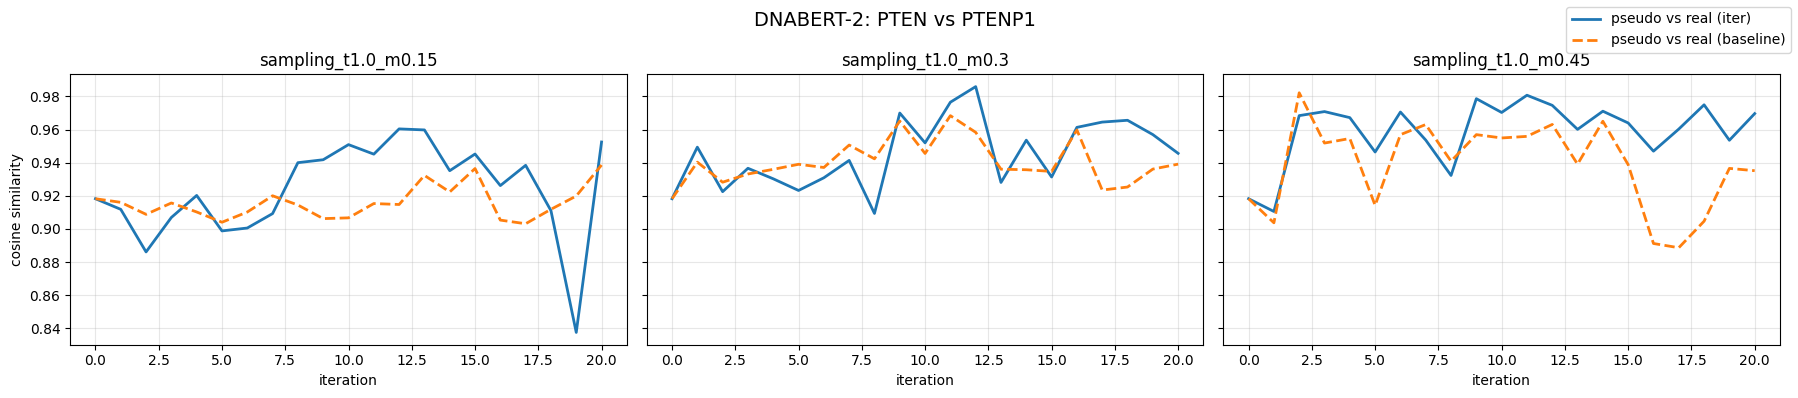

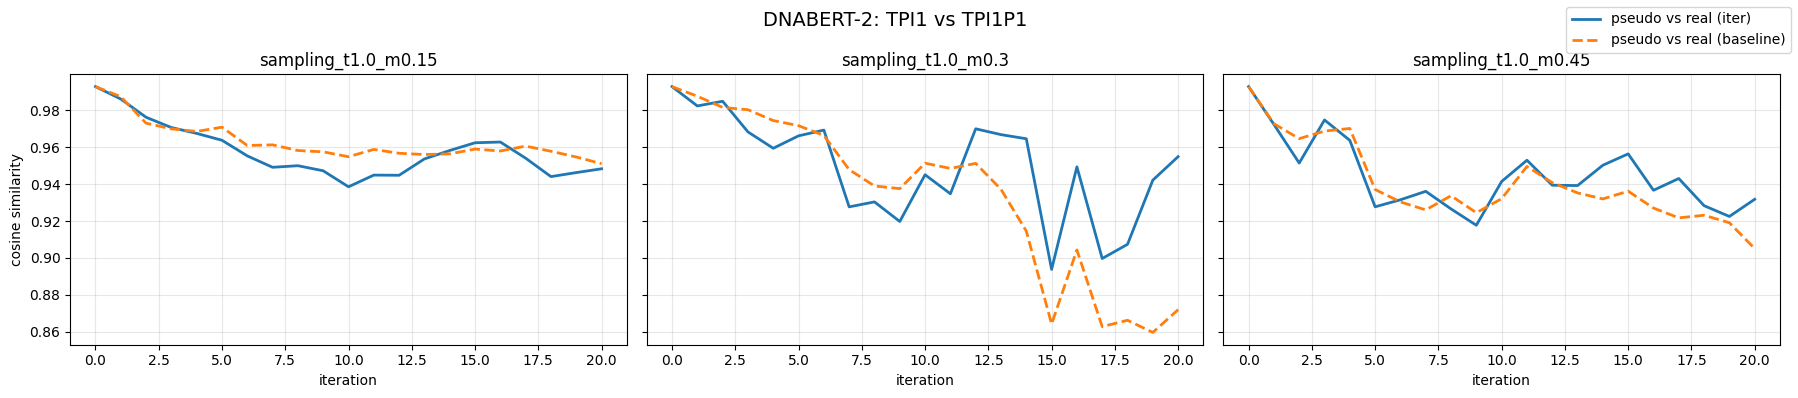

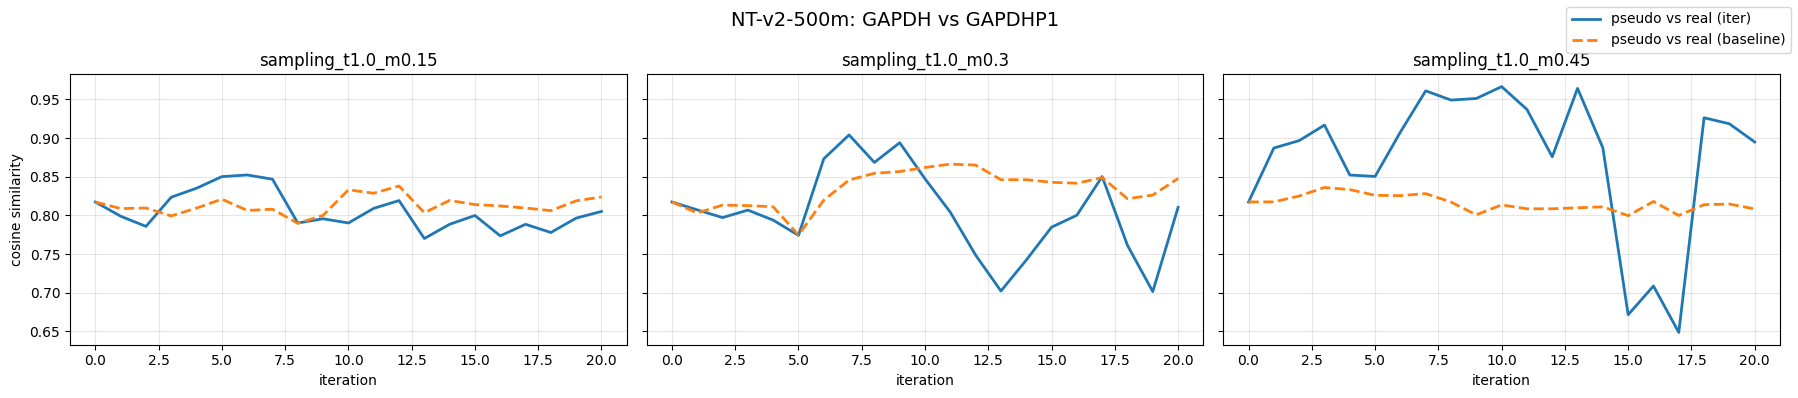

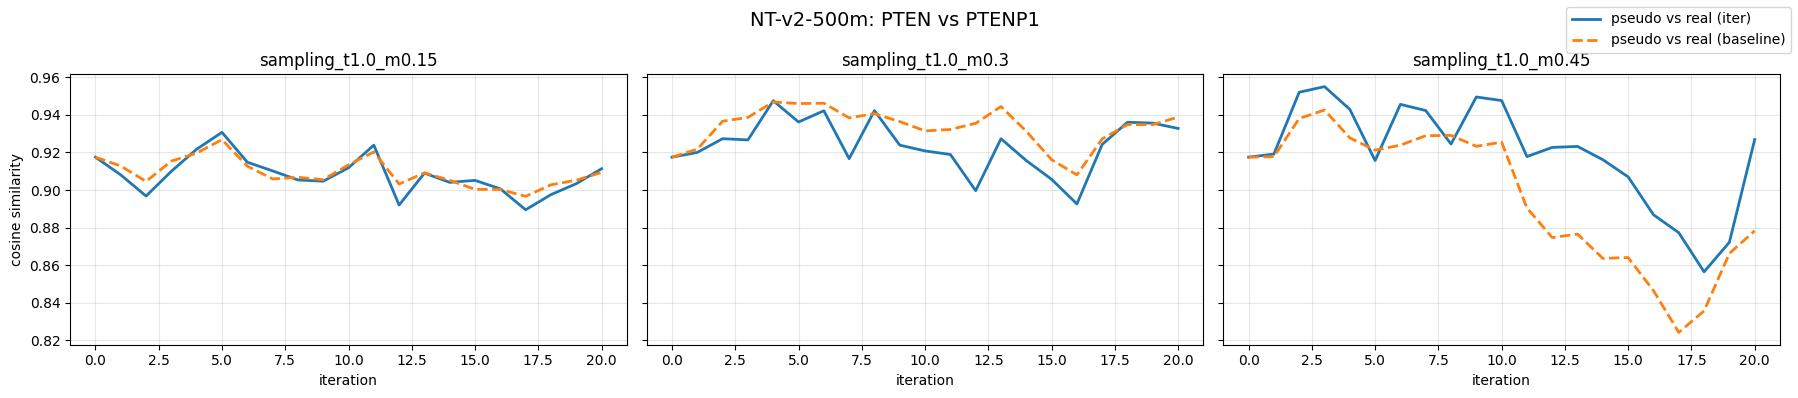

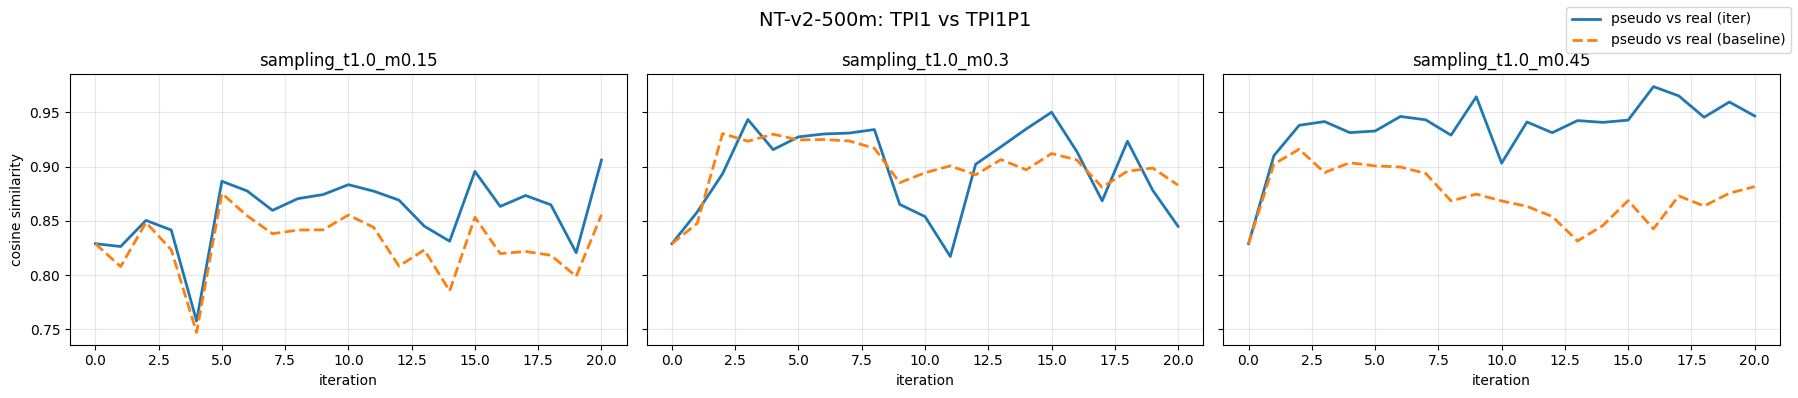

In [7]:
# Similarity plotting (per gene, per model): cosine vs baseline
def cosine_similarity_per_iter(a, b):
    dot = np.sum(a * b, axis=1)
    denom = np.linalg.norm(a, axis=1) * np.linalg.norm(b, axis=1)
    return dot / np.clip(denom, 1e-9, None)

for model_label in models.keys():
    for real_gene, pseudo_gene in GENE_PAIRS:
        real_strategies = set(embedding_data[model_label][real_gene].keys())
        pseudo_strategies = set(embedding_data[model_label][pseudo_gene].keys())
        strategies = sorted(real_strategies & pseudo_strategies, key=parse_mask_ratio)

        if not strategies:
            print(f'No shared strategies for {model_label} {real_gene}-{pseudo_gene}')
            continue

        axes = np.atleast_1d(plt.subplots(1, len(strategies), figsize=(6 * len(strategies), 4), sharey=True)[1])
        plt.suptitle(f'{model_label}: {real_gene} vs {pseudo_gene}', fontsize=14)

        for idx, strategy in enumerate(strategies):
            ax = axes[idx]
            real_emb = embedding_data[model_label][real_gene][strategy]
            pseudo_emb = embedding_data[model_label][pseudo_gene][strategy]

            # Cosine similarity per iteration: pseudo_t vs real_t
            cos_sim = cosine_similarity_per_iter(pseudo_emb, real_emb)

            # Baseline comparison: pseudo_t vs real_baseline (iteration 0)
            real_baseline = real_emb[0]
            baseline_sim = (pseudo_emb @ real_baseline) / (
                np.linalg.norm(pseudo_emb, axis=1) * np.linalg.norm(real_baseline)
            )

            ax.plot(cos_sim, label='pseudo vs real (iter)', linewidth=2)
            ax.plot(baseline_sim, label='pseudo vs real (baseline)', linestyle='--', linewidth=2)
            ax.set_title(strategy)
            ax.set_xlabel('iteration')
            if idx == 0:
                ax.set_ylabel('cosine similarity')
            ax.grid(True, alpha=0.3)

        handles, labels = axes[-1].get_legend_handles_labels()
        plt.figlegend(handles, labels, loc='upper right')
        plt.tight_layout()
        plt.show()


DNABERT-2 GAPDH-GAPDHP1 PCA input: rows=126, max_abs=4.068e+00
DNABERT-2 PTEN-PTENP1 PCA input: rows=126, max_abs=4.744e+00
DNABERT-2 TPI1-TPI1P1 PCA input: rows=126, max_abs=4.993e+00


/opt/homebrew/Cellar/micromamba/envs/dna-fm/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Cellar/micromamba/envs/dna-fm/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Cellar/micromamba/envs/dna-fm/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Cellar/micromamba/envs/dna-fm/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Cellar/micromamba/envs/dna-fm/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.

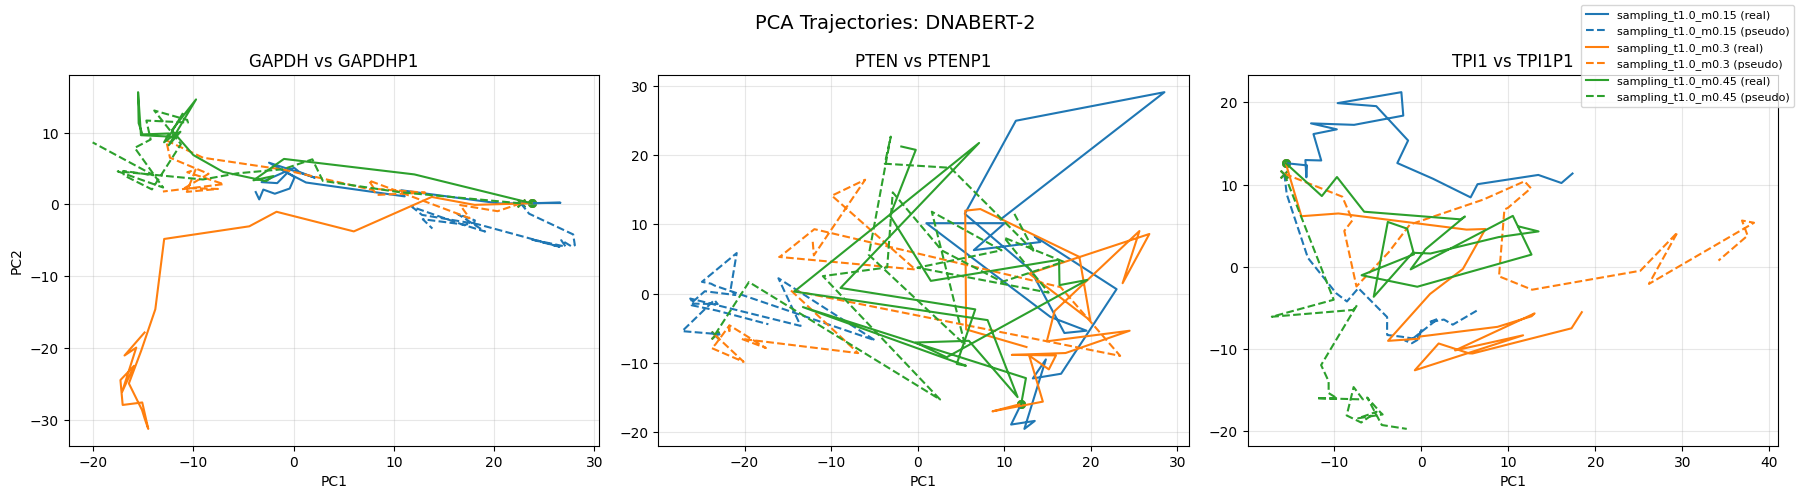

NT-v2-500m GAPDH-GAPDHP1 PCA input: rows=126, max_abs=5.025e+00
NT-v2-500m PTEN-PTENP1 PCA input: rows=126, max_abs=4.539e+00
NT-v2-500m TPI1-TPI1P1 PCA input: rows=126, max_abs=4.410e+00


/opt/homebrew/Cellar/micromamba/envs/dna-fm/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Cellar/micromamba/envs/dna-fm/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Cellar/micromamba/envs/dna-fm/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Cellar/micromamba/envs/dna-fm/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Cellar/micromamba/envs/dna-fm/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.

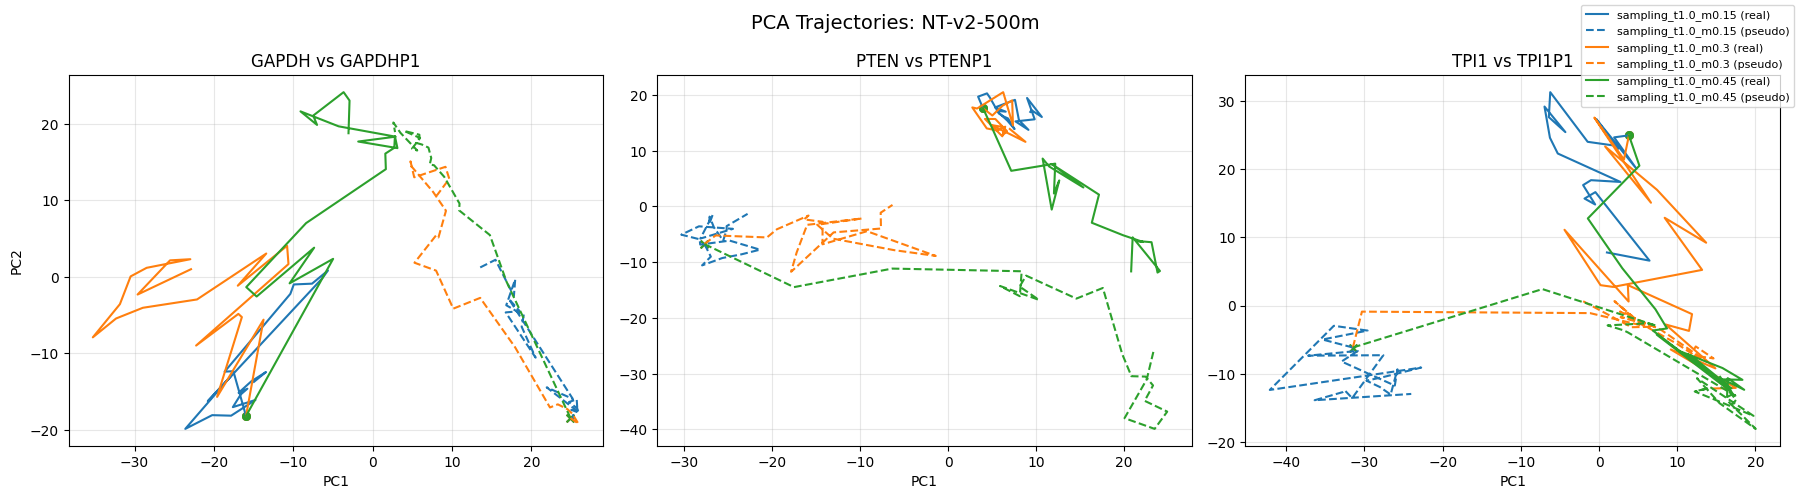

: 

In [ ]:
# PCA trajectories (gene-pair subplots per model)
def sanitize_embeddings(x, clip_value=1e6):
    x = np.asarray(x, dtype=np.float64)
    finite_mask = np.isfinite(x)
    if not finite_mask.all():
        bad = np.size(x) - np.count_nonzero(finite_mask)
        print(f'Warning: {bad} non-finite values detected; replacing with 0')
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    if clip_value is not None:
        x = np.clip(x, -clip_value, clip_value)
    return x

def normalize_rows(x, eps=1e-12):
    norms = np.linalg.norm(x, axis=1, keepdims=True)
    return x / np.clip(norms, eps, None)

def fit_pca_for_pair(model_label, real_gene, pseudo_gene, strategies):
    all_embeds = []
    for strategy in strategies:
        all_embeds.append(embedding_data[model_label][real_gene][strategy])
        all_embeds.append(embedding_data[model_label][pseudo_gene][strategy])
    all_embeds = np.vstack(all_embeds)
    all_embeds = sanitize_embeddings(all_embeds)

    # Remove any rows that are all zeros after sanitization
    non_zero = np.any(all_embeds != 0.0, axis=1)
    all_embeds = all_embeds[non_zero]

    if all_embeds.shape[0] < 2:
        return None, None

    # Row-normalize to reduce overflow risk
    all_embeds = normalize_rows(all_embeds)

    scaler = StandardScaler(with_mean=True, with_std=True)
    all_embeds = scaler.fit_transform(all_embeds)

    # Diagnostic stats
    print(f'{model_label} {real_gene}-{pseudo_gene} PCA input: rows={all_embeds.shape[0]}, max_abs={np.max(np.abs(all_embeds)):.3e}')

    pca = PCA(n_components=2, svd_solver='full')
    pca.fit(all_embeds)
    return pca, scaler

for model_label in models.keys():
    fig, axes = plt.subplots(1, len(GENE_PAIRS), figsize=(6 * len(GENE_PAIRS), 5), sharex=False, sharey=False)
    axes = np.atleast_1d(axes)
    fig.suptitle(f'PCA Trajectories: {model_label}', fontsize=14)

    for idx, (real_gene, pseudo_gene) in enumerate(GENE_PAIRS):
        ax = axes[idx]
        real_strategies = set(embedding_data[model_label][real_gene].keys())
        pseudo_strategies = set(embedding_data[model_label][pseudo_gene].keys())
        strategies = sorted(real_strategies & pseudo_strategies, key=parse_mask_ratio)

        if not strategies:
            ax.set_title(f'{real_gene} vs {pseudo_gene} (no shared strategies)')
            ax.axis('off')
            continue

        color_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', [])
        color_map = {
            strategy: color_cycle[i % len(color_cycle)]
            for i, strategy in enumerate(strategies)
        }

        pca, scaler = fit_pca_for_pair(model_label, real_gene, pseudo_gene, strategies)
        if pca is None:
            ax.set_title(f'{real_gene} vs {pseudo_gene} (insufficient data)')
            ax.axis('off')
            continue

        for strategy in strategies:
            real_emb = sanitize_embeddings(embedding_data[model_label][real_gene][strategy])
            pseudo_emb = sanitize_embeddings(embedding_data[model_label][pseudo_gene][strategy])

            real_emb = normalize_rows(real_emb)
            pseudo_emb = normalize_rows(pseudo_emb)

            real_emb = scaler.transform(real_emb)
            pseudo_emb = scaler.transform(pseudo_emb)

            real_2d = pca.transform(real_emb)
            pseudo_2d = pca.transform(pseudo_emb)

            ax.plot(real_2d[:, 0], real_2d[:, 1], color=color_map[strategy], label=f'{strategy} (real)')
            ax.plot(pseudo_2d[:, 0], pseudo_2d[:, 1], color=color_map[strategy], linestyle='--', label=f'{strategy} (pseudo)')
            ax.scatter(real_2d[0, 0], real_2d[0, 1], color=color_map[strategy], marker='o', s=30)
            ax.scatter(pseudo_2d[0, 0], pseudo_2d[0, 1], color=color_map[strategy], marker='x', s=30)

        ax.set_title(f'{real_gene} vs {pseudo_gene}')
        ax.set_xlabel('PC1')
        if idx == 0:
            ax.set_ylabel('PC2')
        ax.grid(True, alpha=0.3)

    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.show()
